In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pc-setup-detector-dataset/final/labels/val/84.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/383.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/115.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/127.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/356.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/155.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/398.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/299.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/253.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/151.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/51.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/373.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/323.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/88.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/435.txt
/kaggle/input/pc-setup-detec

In [2]:
import torch
from IPython.display import Image
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [3]:
mapping = {
    "Phone/Tablet":0,
    "Laptop": 1,
    "TV/Monitor": 2,
    "Keyboard": 3,
    "Mouse":4
}

In [4]:
!cp -R /kaggle/input/pc-setup-detector-dataset /kaggle/working/

In [5]:
ann_path ="/kaggle/working/pc-setup-detector-dataset/final/labels/train"
annotations = [os.path.join(ann_path, x) for x in os.listdir(ann_path) if x[-3:]=="txt"]

/kaggle/working/pc-setup-detector-dataset/final/images/train/54.png /kaggle/working/pc-setup-detector-dataset/final/labels/train/54.txt


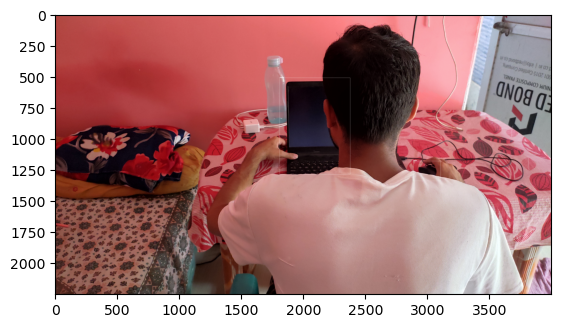

In [6]:
random.seed(1000)
class_id_to_name = dict(zip(mapping.values(), mapping.keys()))

def plot_bbox(img, ann_list):
    annotations = np.array(ann_list)
    w,h = img.size
    
    plotted_img = ImageDraw.Draw(img)
    
    plotted_image = ImageDraw.Draw(img)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0, y0), (x1, y1)))
        plotted_image.text((x0, y0-10), class_id_to_name[(int(obj_cls))])
    plt.imshow(np.array(img))
    plt.show()

annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    ann_list = file.read().split("\n")[:-1]
    ann_list = [x.split(" ") for x in ann_list]
    ann_list = [[float(y) for y in x] for x in ann_list]

img_file = annotation_file.replace("labels", "images").replace("txt", "png")
print(img_file, annotation_file)
assert os.path.exists(img_file)
img = Image.open(img_file)
plot_bbox(img, ann_list)

In [7]:
!git clone https://github.com/WongKinYiu/yolov7.git

Cloning into 'yolov7'...
remote: Enumerating objects: 1185, done.
remote: Total 1185 (delta 0), reused 0 (delta 0), pack-reused 1185
Receiving objects: 100% (1185/1185), 74.22 MiB | 22.96 MiB/s, done.
Resolving deltas: 100% (511/511), done.


In [8]:
import yaml

with open(r'/kaggle/input/data-pc-detection/detector.yaml') as file:
    list = yaml.load(file, Loader=yaml.FullLoader)
    print(list)

{'train': '/kaggle/working/pc-setup-detector-dataset/final/images/train', 'val': '/kaggle/working/pc-setup-detector-dataset/final/images/val', 'test': '/kaggle/working/pc-setup-detector-dataset/final/images/test', 'nc': 5, 'names': ['Phone/Tablet', 'Laptop', 'TV/Monitor', 'Keyboard', 'Mouse']}


In [9]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api_key")
wandb.login(key = secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [10]:
!python /kaggle/working/yolov7/train.py --img 640 --cfg /kaggle/working/yolov7/cfg/training/yolov7.yaml --hyp /kaggle/working/yolov7/data/hyp.scratch.custom.yaml --batch 8 --epochs 100 --data /kaggle/input/data-pc-detection/detector.yaml  --weights /kaggle/input/training-pt/yolov7_training.pt  --workers 24 --name yolo_road_det 

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso